In [2]:
### Initialize ###

from pylab import *
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.collections import LineCollection
%matplotlib inline
# Normal matplotlib => just wrap in $ for latex

import mpld3
mpld3.enable_notebook()

from sklearn import gaussian_process



### Read in data ###

def_path = '../Data/models.dat'
data = matrix(genfromtxt(def_path))
data = asarray(data)

data = data.T
matrix = np.reshape(data,[46,270,400])
matrix = np.swapaxes(matrix,0,1)

# Now, the data is in a 3D matrix of the form [ICs, parameters, steps]
print 'The data matrix has dimensions of:'
print shape(matrix)


### Now, I need to pick out 2 variables to hold as fixed, 1 to change ###

'''
fixed[x,y]: Mini = 0, Zini = 1, O/Ocini = 2
  * Initial mass values:
    1.7 2.0 2.5 3.0 4.0 5.0 7.0 9.0 12.0 15.0
  * Initial Z values:
    0.002 0.006 0.014
  * Initial {Omega}/{Omega}_crit_ values:
    0.00 0.10 0.30 0.50 0.60 0.70 0.80 0.90 0.95
'''

def pick_ICs(IC1, IC2, IC1_val, IC2_val):
    cut_data=[]
    for i in xrange(0,len(matrix)):
        if matrix[i,IC1,0]==IC1_val and matrix[i,IC2,0]==IC2_val:
            cut_data.append(matrix[i])
    return cut_data

'''Adjust these values to interpolate over a different 1D prior!!!'''
cut = pick_ICs(0, 1, 4.0, 0.014)

print 'The sample matrix has dimensions of:'
print shape(cut)

The data matrix has dimensions of:
(270, 46, 400)
The sample matrix has dimensions of:
(9, 46, 400)


## Plot time evolution of the independent parameter and an HR diagram

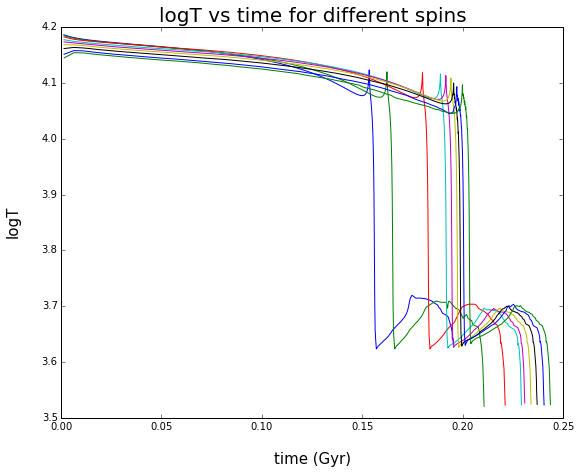

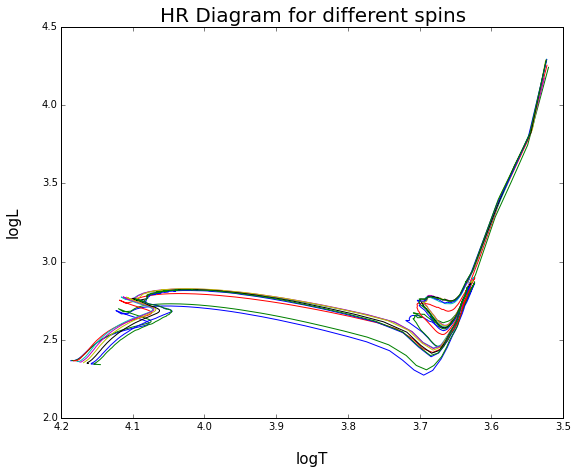

In [3]:
### Plot each evolutionary track for these ICs ###

fig=plt.figure(figsize = (9,7), facecolor = 'white')
plt.xlabel('time (Gyr)', labelpad=20, size=15)
plt.ylabel('logT', rotation=90, labelpad=20, size=15)
plt.title('logT vs time for different spins', size=20)


'''
--------------------------------------------------------------------------------
0: Mini, 1: Zini, 2: OOcini, 3: Line, 4: Time, 5: Mass, 6: logL, 7: logTe,
21: logDm/dt, 22: log(rhoc), 23: logTc, 35: OmegaS, 36: OmegaC, 37: RpRe, 
41: veq, 42: OOc, 43: Gedd, 44: dM/dtm, 45: Ltot
--------------------------------------------------------------------------------
'''
time_evo_param = 7
def plot_time(run):
    q = cut[run]
    plt.plot(q[4,:]/(10**9), q[time_evo_param,:])

for i in xrange(len(cut)):
    plot_time(i)
    


### Plot HR Diagram for these runs ###

fig=plt.figure(figsize = (9,7), facecolor = 'white')
plt.xlabel('logT', labelpad=20, size=15)
plt.ylabel('logL', rotation=90, labelpad=20, size=15)
plt.title('HR Diagram for different spins', size=20)

plt.gca().invert_xaxis()

def plot_HR(data,run):
    q = data[run]
    plt.plot(q[7,:], q[6,:])

for i in xrange(0,len(cut)):
    plot_HR(cut,i)

## Run & Plot Gaussian Process

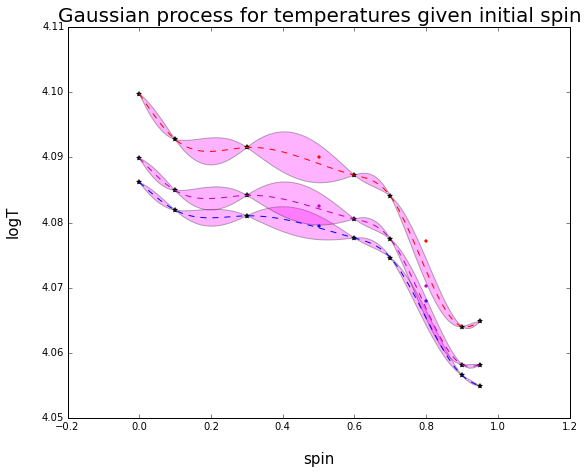

In [7]:
### Choose the varying input parameter and output parameter of the GP: parameters=[(0,1,2),(3:46)] ###
parameters=[2,7]

'''
--------------------------------------------------------------------------------
0: Mini, 1: Zini, 2: OOcini, 3: Line, 4: Time, 5: Mass, 6: logL, 7: logTe,
21: logDm/dt, 22: log(rhoc), 23: logTc, 35: OmegaS, 36: OmegaC, 37: RpRe, 
41: veq, 42: OOc, 43: Gedd, 44: dM/dtm, 45: Ltot
--------------------------------------------------------------------------------
'''

def GP(x, y):
    gp = gaussian_process.GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
    ''' other corr: 'absolute_exponential', 'squared_exponential', 'generalized_exponential', 'cubic', 'linear' '''
    x = np.atleast_2d(x).T
    y = np.atleast_2d(y).T
    
    gp.fit(x, y)
    
    # Create an array of prediction points between the minimum and maximum values
    x_pred = np.atleast_2d(np.linspace(array(cut)[:,2,0].min(),array(cut)[:,2,0].max(),100)).T
    y_pred, sigma2_pred = gp.predict(x_pred, eval_MSE=True)
    sigma = sqrt(sigma2_pred)
    
    return x_pred, y_pred, sigma


### Pick out training and testing points for the spin ICs ###
trainpts=[0,1,2,4,5,7,8]
testpts=[3,6]

training=[]
for i in trainpts:
    training.append(cut[i])

testing=[]
for i in testpts:
    testing.append(cut[i])


### Run GP for each timestep ###
x_pred=[]; y_pred=[]; sigma=[]
for i in xrange(0,400):
    x=[]
    y=[]
    
    x = array(training)[:,parameters[0],i]
    y = array(training)[:,parameters[1],i]
    x_GP, y_GP, sigma_GP = GP(x,y)
    
    x_pred.append(x_GP)
    y_pred.append(y_GP)
    sigma.append(sigma_GP)


    
    
    
### Plot a few tracks with testing points, training points, and GP ###

def plot(x_obs, y_obs, x_pred, y_pred, x_act, y_act, sigma):
    # Error
    plt.fill_between(np.ravel(x_pred), (np.ravel(y_pred)-sigma), 
                     (np.ravel(y_pred)+sigma), facecolor='magenta', alpha=.3)
    # Observations
    plt.scatter(x_obs, y_obs, color = 'k', marker='*')
    # Predictions
    plt.plot(x_pred, y_pred, color=colors[i], linestyle='--')
    # Actual
    plt.scatter(x_act, y_act, color=colors[i], marker='.')
    

fig=plt.figure(figsize = (9,7), facecolor = 'white')
plt.xlabel('spin', rotation=0, labelpad=20, size=15)
plt.ylabel('logT', rotation=90, labelpad=20, size=15)
plt.title('Gaussian process for temperatures given initial spin', size=20)

colors=['r','g','b','y','m','g','k']*100
times=[100,102,105]   ### Adjust this to plot different timesteps

for i in times:
    x_obs = array(training)[:,parameters[0],i]
    y_obs = array(training)[:,parameters[1],i]
    x_act = array(testing)[:,parameters[0],i]
    y_act = array(testing)[:,parameters[1],i]
    x_pred_step = x_pred[i]
    y_pred_step = y_pred[i]
    sigma_step = sigma[i]
    plot(x_obs, y_obs, x_pred_step, y_pred_step, x_act, y_act, sigma_step)



## Plot HR Diagram for interpolated runs

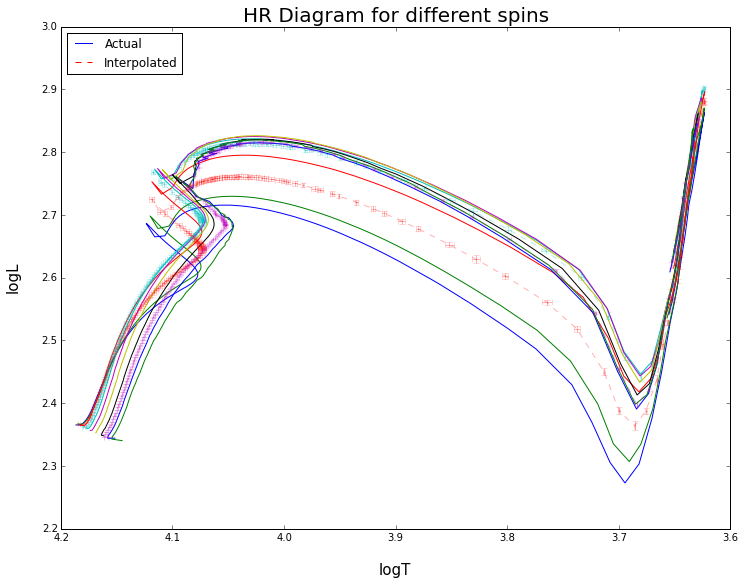

In [52]:
'''First, we define the values of initial condition to interpolate over'''
interp=[0.2,0.4,0.85]


# Instead of getting estimates over a 'continuous' range, we just pick out the values of interp
def GP_discrete(x, y):
    gp = gaussian_process.GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
    ### corr: 'absolute_exponential', 'squared_exponential', 'generalized_exponential', 'cubic', 'linear' ###
    x = np.atleast_2d(x).T
    y = np.atleast_2d(y).T
    gp.fit(x, y)
    
    # Create an array of prediction points between the minimum and maximum values
    x_pred = np.atleast_2d(interp).T      # Gives the values of the spin at which we want a predicton
    y_pred, sigma2_pred = gp.predict(x_pred, eval_MSE=True)
    sigma = sqrt(sigma2_pred)
    
    return y_pred, sigma   # No need to return x_pred, since this is the same as interp


'''
--------------------------------------------------------------------------------
0: Mini, 1: Zini, 2: OOcini, 3: Line, 4: Time, 5: Mass, 6: logL, 7: logTe,
21: logDm/dt, 22: log(rhoc), 23: logTc, 35: OmegaS, 36: OmegaC, 37: RpRe, 
41: veq, 42: OOc, 43: Gedd, 44: dM/dtm, 45: Ltot
--------------------------------------------------------------------------------
'''

### Run GP for temperature for each timestep ###
temp_pred=[]; temp_sigma=[]
for i in xrange(0,400):
    x=[]
    y=[]
    
    x = array(cut)[:,parameters[0],i]
    y = array(cut)[:,7,i]   # 7 is the temperature...see above
    y_GP, sigma_GP = GP_discrete(x,y)
    
    temp_pred.append(y_GP)
    temp_sigma.append(sigma_GP)
    
temp_pred = np.swapaxes(array(temp_pred),0,1)
temp_sigma = np.swapaxes(array(temp_sigma),0,1)

### Run GP for luminosity for each timestep ###
parameters=[2,6]
lum_pred=[]; lum_sigma=[]
for i in xrange(0,400):
    x=[]
    y=[]
    
    x = array(cut)[:,parameters[0],i]
    y = array(cut)[:,6,i]   # 6 is the temperature...see above
    y_GP, sigma_GP = GP_discrete(x,y)
    
    lum_pred.append(y_GP)
    lum_sigma.append(sigma_GP)
    
lum_pred = np.swapaxes(array(lum_pred),0,1)
lum_sigma = np.swapaxes(array(lum_sigma),0,1)


### Plot the observed and interpolated runs in an HR diagram ###
fig=plt.figure(figsize = (12,9), facecolor = 'white')
plt.xlabel('logT', labelpad=20, size=15)
plt.ylabel('logL', rotation=90, labelpad=20, size=15)
plt.title('HR Diagram for different spins', size=20)

'''
--------------------------------------------------------------------------------
0: Mini, 1: Zini, 2: OOcini, 3: Line, 4: Time, 5: Mass, 6: logL, 7: logTe,
21: logDm/dt, 22: log(rhoc), 23: logTc, 35: OmegaS, 36: OmegaC, 37: RpRe, 
41: veq, 42: OOc, 43: Gedd, 44: dM/dtm, 45: Ltot
--------------------------------------------------------------------------------
'''

plt.gca().invert_xaxis()

# Min and Max time to plot
min=0
max=200

# Plot runs
for i in xrange(len(cut)):
    q = cut[i]
    plt.plot(q[7,min:max], q[6,min:max])

# Plot interpolations
for i in xrange(len(temp_pred)):
    plt.errorbar(temp_pred[i,min:max,0], lum_pred[i,min:max,0], xerr=temp_sigma[i,min:max], 
                 yerr=lum_sigma[i,min:max], linestyle='--', alpha=.3)
    
#set up the line collections
lc1 = LineCollection([[(0, 0)]], linestyles = ['solid'], colors = ['blue'])
lc2 = LineCollection([[(0, 0)]], linestyles = ['dashed'], colors = ['red'])
lc3 = LineCollection([[(0, 0)]], linestyles = ['dotted'], colors = ['green'])
#create the legend
plt.legend([lc1, lc2], ['Actual', 'Interpolated'], loc=2)


## Hold Out Cross Validation

(400,)
[0.5]


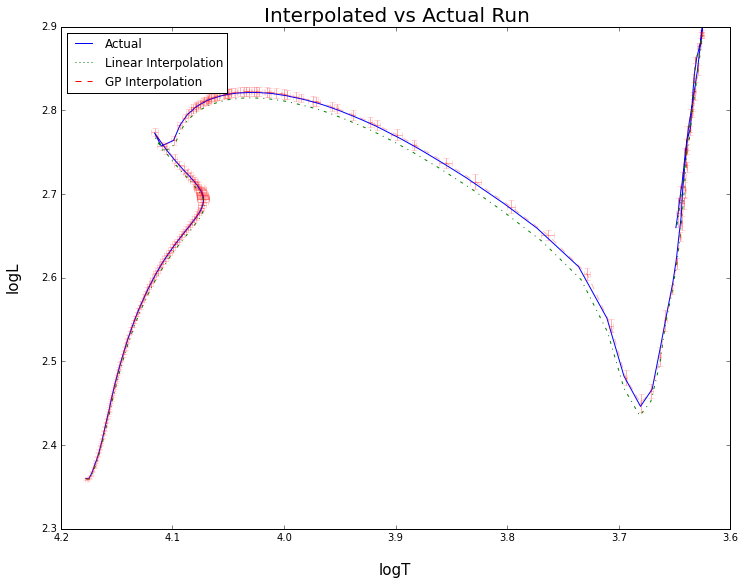

In [54]:
### Run the same as above to make an HR diagram, but hold out 1 of the initial conditions
### and interpolate over this, then compare with the actual evolutionary track


'''
fixed[x,y]: Mini = 0, Zini = 1, O/Ocini = 2
  * Initial mass values:
    1.7 2.0 2.5 3.0 4.0 5.0 7.0 9.0 12.0 15.0
  * Initial Z values:
    0.002 0.006 0.014
  * Initial {Omega}/{Omega}_crit_ values:
    0.00 0.10 0.30 0.50 0.60 0.70 0.80 0.90 0.95
'''

trainpts=[0,1,2,4,5,6,7,8]
testpts=[3]

training=[]
for i in trainpts:
    training.append(cut[i])

testing=[]
for i in testpts:
    testing.append(cut[i])

interp=[]
for i in xrange(len(testing)):
    interp.append(array(testing)[i,parameters[0],0])     # This is the value of omega to interpolate over  
   


### Run GP for temperature for each timestep ###
temp_pred=[]; temp_sigma=[]
for i in xrange(0,400):
    x=[]
    y=[]
    
    x = array(training)[:,parameters[0],i]
    y = array(training)[:,7,i]   # 7 is the temperature...see above
    y_GP, sigma_GP = GP_discrete(x,y)
    
    temp_pred.append(y_GP)
    temp_sigma.append(sigma_GP)
    
temp_pred = np.swapaxes(array(temp_pred),0,1)
temp_sigma = np.swapaxes(array(temp_sigma),0,1)

### Run GP for lum for each timestep ###
parameters=[2,6]
lum_pred=[]; lum_sigma=[]
for i in xrange(0,400):
    x=[]
    y=[]
    
    x = array(training)[:,parameters[0],i]
    y = array(training)[:,6,i]   # 6 is the temperature...see above
    y_GP, sigma_GP = GP_discrete(x,y)
    
    lum_pred.append(y_GP)
    lum_sigma.append(sigma_GP)
    
lum_pred = np.swapaxes(array(lum_pred),0,1)
lum_sigma = np.swapaxes(array(lum_sigma),0,1)

#Do a linear interpolation for the same data
Llinear=[];
from scipy.interpolate import interp1d
for i in xrange(0,400):
    x=[]
    y=[]
    
    x = array(training)[:,parameters[0],i]
    y = array(training)[:,6,i]   # 6 is the luminosity...see above
    Llinear.append(interp1d(x,y))
    
print shape(Llinear)

Tlinear=[];
from scipy.interpolate import interp1d
for i in xrange(0,400):
    x=[]
    y=[]
    
    x = array(training)[:,parameters[0],i]
    y = array(training)[:,7,i]   # 7 is the temperature...see above
    Tlinear.append(interp1d(x,y))



### Plot the observed and interpolated runs in an HR diagram ###
#fig=plt.figure(figsize = (12,9), facecolor = 'white')
#plt.xlabel('logT', labelpad=20, size=15)
#plt.ylabel('logL', rotation=90, labelpad=20, size=15)
#plt.title('HR Diagram for different spins', size=20)

#plt.gca().invert_xaxis()

# Min and Max time to plot
min=0
max=200

# Plot runs
#for i in xrange(len(training)):
 #   q = training[i]
  #  plt.plot(q[7,min:max], q[6,min:max])

# Plot interpolations
#for i in xrange(len(temp_pred)):
 #   plt.errorbar(temp_pred[i,min:max,0], lum_pred[i,min:max,0], xerr=temp_sigma[i,min:max], 
  #               yerr=lum_sigma[i,min:max], linestyle='--', alpha=.3)

#plt.legend([lc1, lc2], ['Actual', 'Interpolated'], loc=2)




### Now, compare the interpolated run with the actual run ###

fig=plt.figure(figsize = (12,9), facecolor = 'white')
plt.xlabel('logT', labelpad=20, size=15)
plt.ylabel('logL', rotation=90, labelpad=20, size=15)
plt.title('Interpolated vs Actual Run', size=20)

plt.gca().invert_xaxis()

Tplot=[]; Lplot=[];

print Tlinear[0]
print interp
for i in xrange(200):
    Tplot.append(Tlinear[i](interp));
    Lplot.append(Llinear[i](interp));


# Plot run
for i in xrange(len(testing)):
    q = testing[i]
    plt.plot(q[7,min:max], q[6,min:max])
    
plt.plot(Tplot,Lplot, linestyle ='-.')

# Plot interpolation
for i in xrange(len(temp_pred)):
    plt.errorbar(temp_pred[i,min:max,0], lum_pred[i,min:max,0], xerr=temp_sigma[i,min:max], 
                 yerr=lum_sigma[i,min:max], linestyle='--', alpha=.3)
    
plt.legend([lc1,lc3,lc2], ['Actual', 'Linear Interpolation', 'GP Interpolation'], loc=2)

In [61]:
### Compute Chi Squared ###
# Chi-Squared: Sum of ((O-E)**2)/E

index = 0    # Which index in the array interp to compute Chi Squared for
obs_temp = array(testing)[0,7,min:max]
obs_lum = array(testing)[0,6,min:max]
exp_temp = array(temp_pred[index,min:max,0])
exp_lum = array(lum_pred[index,min:max,0])
exp_temp_lin = Tplot;
exp_lum_lin = Lplot;

chi_temp=0
chi_temp_lin =0
i=0
while i < len(obs_temp):
    q = ((obs_temp[i]-exp_temp[i])**2)/exp_temp[i]
    q2 = ((obs_temp[i]-exp_temp_lin[i])**2)/exp_temp_lin[i]
    chi_temp = chi_temp + q
    chi_temp_lin = chi_temp_lin +q2
    i+=1
    
chi_lum=0
chi_lum_lin =0
i=0
while i < len(obs_lum):
    q = ((obs_lum[i]-exp_lum[i])**2)/exp_lum[i]
    q2 = ((obs_lum[i]-exp_lum_lin[i])**2)/exp_lum_lin[i]
    chi_lum = chi_lum + q
    chi_lum_lin = chi_lum_lin + q2
    i+=1

# Add in quadrature
chi_squared=sqrt(chi_temp**2 + chi_lum**2)
chi_squared_lin = sqrt(chi_temp_lin**2 + chi_lum_lin**2)
    
print 'The chi-squared for temperature is %f' %chi_temp, 'and for linear interpolation is %f' %chi_temp_lin
print 'The chi-squared for luminosity is %f' %chi_lum, 'and for linear interpolation is %f' %chi_lum_lin
print 'The total chi-squared is %f' %chi_squared, 'and %f' %chi_squared_lin, 'for linear'

The chi-squared for temperature is 0.000164 and for linear interpolation is 0.000079
The chi-squared for luminosity is 0.001125 and for linear interpolation is 0.003118
The total chi-squared is 0.001137 and 0.003119 for linear


### Different Correlation Functions

The chi-squared for the absolute_exponential correlation function is:
0.000134380797235
The chi-squared for the squared_exponential correlation function is:
0.000124897942096
The chi-squared for the cubic correlation function is:
0.000124391567555
The chi-squared for the linear correlation function is:
0.000134506376545


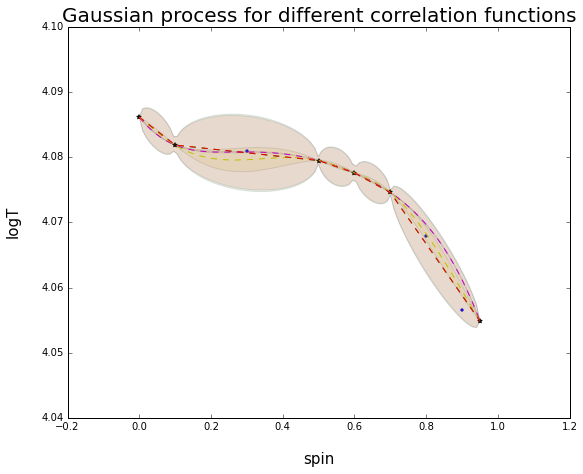

In [10]:
'''Now, let's plot the interpolations and determine the Chi Squared for differing correlations
in the Gaussian Process algorithm. Similar treatment as above. '''

correlations=array(['absolute_exponential', 'squared_exponential', 'cubic', 'linear'])  # Got rid of gen exp, gave errors

### Choose the varying input parameter and output parameter of the GP: parameters=[(0,1,2),(3:46)] ###
parameters=[2,7]

'''
--------------------------------------------------------------------------------
0: Mini, 1: Zini, 2: OOcini, 3: Line, 4: Time, 5: Mass, 6: logL, 7: logTe,
21: logDm/dt, 22: log(rhoc), 23: logTc, 35: OmegaS, 36: OmegaC, 37: RpRe, 
41: veq, 42: OOc, 43: Gedd, 44: dM/dtm, 45: Ltot
--------------------------------------------------------------------------------
'''

def GP_corr(x, y):
    gp = gaussian_process.GaussianProcess(corr=correlations[i], theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
    x = np.atleast_2d(x).T
    y = np.atleast_2d(y).T
    
    gp.fit(x, y)
    
    # Create an array of prediction points between the minimum and maximum values
    x_pred = np.atleast_2d(np.linspace(array(cut)[:,parameters[0],0].min(),array(cut)[:,parameters[0],0].max(),100)).T
    y_pred, sigma2_pred = gp.predict(x_pred, eval_MSE=True)
    sigma = sqrt(sigma2_pred)
    
    return x_pred, y_pred, sigma


### Pick out training and testing points for the spin ICs ###
trainpts=[0,1,3,4,5,8]
testpts=[2,6,7]

training=[]
for i in trainpts:
    training.append(cut[i])

testing=[]
for i in testpts:
    testing.append(cut[i])


step=100 # This is the timestep that we're running the Gaussian Process on

x_obs = array(training)[:,parameters[0],step]
y_obs = array(training)[:,parameters[1],step]
x_act = array(testing)[:,parameters[0],step]
y_act = array(testing)[:,parameters[1],step]

### Plot everything ###
fig=plt.figure(figsize = (9,7), facecolor = 'white')
plt.xlabel('spin', rotation=0, labelpad=20, size=15)
plt.ylabel('logT', rotation=90, labelpad=20, size=15)
plt.title('Gaussian process for different correlation functions', size=20)

# Observations
plt.scatter(x_obs, y_obs, color = 'k', marker='*')
# Actual
plt.scatter(x_act, y_act, color= 'b', marker='.')



### Run GP for the timestep above with different correlations and plot ###
x = array(training)[:,parameters[0],step]
y = array(training)[:,parameters[1],step]

colors=['g','m','y','r']
for i in xrange(len(correlations)):
    x_pred, y_pred, sigma = GP_corr(x,y)
    plt.plot(x_pred, y_pred, color=colors[i], linestyle='--')
    plt.fill_between(np.ravel(x_pred), (np.ravel(y_pred)-sigma), 
                     (np.ravel(y_pred)+sigma), facecolor=colors[i], alpha=.1)
    




'''Compute Chi Squared for each correlation functions'''

x_act = array(testing)[:,parameters[0],step]
y_act = array(testing)[:,parameters[1],step]

def GP_corr_discrete(x, y):
    gp = gaussian_process.GaussianProcess(corr=correlations[i], theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
    x = np.atleast_2d(x).T
    y = np.atleast_2d(y).T
    
    gp.fit(x, y)
    
    # Create an array of prediction points between the minimum and maximum values
    x_pred = np.atleast_2d(x_act).T
    y_pred, sigma2_pred = gp.predict(x_pred, eval_MSE=True)
    sigma = sqrt(sigma2_pred)
    
    return y_pred, sigma   # x_pred is the same as x_act, no need to return

for i in xrange(len(correlations)):
    y_pred, sigma = GP_corr_discrete(x,y)
    chisq = sp.stats.chisquare(y_pred, f_exp=y_act)
    print 'The chi-squared for the %s correlation function is:' %correlations[i]
    print np.mean(chisq[0])


### Generalize to Multiple Dimensions

In [93]:
'''2 dimensional input features'''

'''
fixed[x,y]: Mini = 0, Zini = 1, O/Ocini = 2
  * Initial mass values:
    1.7 2.0 2.5 3.0 4.0 5.0 7.0 9.0 12.0 15.0
  * Initial Z values:
    0.002 0.006 0.014
  * Initial {Omega}/{Omega}_crit_ values:
    0.00 0.10 0.30 0.50 0.60 0.70 0.80 0.90 0.95
'''

features = [0,2]

def pick_one_IC(IC, IC_val):
    cut_data=[]
    for i in xrange(0,len(matrix)):
        if matrix[i,IC,0]==IC_val:
            cut_data.append(matrix[i])
    return cut_data

cut_two = pick_one_IC(1,0.006)


def GP_2d(x, y):
    gp = gaussian_process.GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
    ''' other corr: 'absolute_exponential', 'squared_exponential', 'generalized_exponential', 'cubic', 'linear' '''
    x = np.atleast_2d(x)
    y = np.atleast_2d(y).T
    
    gp.fit(x, y)
    
    # Create an array of prediction points between the minimum and maximum values
    # Add another step here...too complicated
    x_pred = np.atleast_2d(array([(np.linspace(array(cut_two)[:,features[0],0].min(),array(cut_two)[:,features[0],0].max(),100)),
       (np.linspace(array(cut_two)[:,features[1],0].min(),array(cut_two)[:,features[1],0].max(),100))])).T
    y_pred, sigma2_pred = gp.predict(x_pred, eval_MSE=True)
    sigma = sqrt(sigma2_pred)
    
    return x_pred, y_pred, sigma


### Run GP for temperature for each timestep ###
x_pred=[]; y_pred=[]; sigma=[]
for i in xrange(0,400):
    x=[]
    y=[]
    
    x = array(cut_two)[:,features,i]
    y = array(cut_two)[:,7,i]
    x_GP, y_GP, sigma_GP = GP_2d(x,y)
    
    x_pred.append(x_GP)
    y_pred.append(y_GP)
    sigma.append(sigma_GP)


#### N-dimensional input features, M-dimensional output features

In [300]:
'''
fixed[x,y]: Mini = 0, Zini = 1, O/Ocini = 2
  * Initial mass values:
    1.7 2.0 2.5 3.0 4.0 5.0 7.0 9.0 12.0 15.0
  * Initial Z values:
    0.002 0.006 0.014
  * Initial {Omega}/{Omega}_crit_ values:
    0.00 0.10 0.30 0.50 0.60 0.70 0.80 0.90 0.95

--------------------------------------------------------------------------------
0: Mini, 1: Zini, 2: OOcini, 3: Line, 4: Time, 5: Mass, 6: logL, 7: logTe,
21: logDm/dt, 22: log(rhoc), 23: logTc, 35: OmegaS, 36: OmegaC, 37: RpRe, 
41: veq, 42: OOc, 43: Gedd, 44: dM/dtm, 45: Ltot
--------------------------------------------------------------------------------
'''

### Give a value for each input feature to gain a prediction of using Gaussian Processes ###
### Format: [Mini, Zini, O/Ocini] ###
### "matrix" has all the data stored in it from first cell block ###

interpolation = [2.3, 0.008, 0.55],[4.5, 0.004, 0.75],[11.0, 0.013, 0.02]
interpolation = array(interpolation)

x = matrix[:,0:len(interpolation.T),:]   # These are the input features
y = matrix[:,len(interpolation.T):,:]    # These are the output features

def GP_Nd(x, y):
    gp = gaussian_process.GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1)
    ''' other corr: 'absolute_exponential', 'squared_exponential', 'generalized_exponential', 'cubic', 'linear' '''
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    
    gp.fit(x, y)
    
    x_pred = np.atleast_2d(interpolation)
    y_pred, sigma2_pred = gp.predict(x_pred, eval_MSE=True)
    sigma = sqrt(sigma2_pred)
    
    return x_pred, y_pred, sigma


### Run GP for temperature for each timestep ###
x_pred=[]; y_pred=[]; sigma=[]
for i in xrange(0,400):
    x_GP, y_GP, sigma_GP = GP_Nd(x[:,:,i],y[:,:,i])
    
    x_pred.append(x_GP)
    y_pred.append(y_GP)
    sigma.append(sigma_GP)

x_pred = array(x_pred)
y_pred = array(y_pred)
sigma = array(sigma)

### Change form of x_pred, y_pred, & sigma to match matrix###
x_pred = np.swapaxes(x_pred,0,1)
x_pred = np.swapaxes(x_pred,1,2)
y_pred = np.swapaxes(y_pred,0,1)
y_pred = np.swapaxes(y_pred,1,2)
sigma = np.swapaxes(sigma,0,1)

### Now, make a new matrix of the same form with the interpolated data ###
### Form: [initial conditions, output values, timesteps] ###
interp_matrix = hstack((x_pred,y_pred))
print shape(interp_matrix)


(3, 46, 400)
